# Determining parameters


The Fourier transform of the convolutional line profile arising from planar faults, dislocations, and size effects can be evaluated as 

$$
A_{hkl}(L) = A_S(L)A_D(L)A_F(L),
$$

where the variable $L$ is relted to $\kappa$ through the Fourier-transform and $\kappa$ is defined as

$$
\kappa = \frac{2\sin \theta}{\lambda}.
$$

The profile can then be evaluated as 

$$
I(\kappa)_{hkl} = \int_{-\infty}^\infty e^{2\pi i \kappa L}A_{hkl}(L)dL.
$$

The observed spectrum is a linear combination of these. We therefore have to sum over the Miller-indices as

$$
I(\kappa) = \sum_{h,k,l}I_{hkl}^{max}I(\kappa-g_{hkl})_{hkl}.
$$

Generally, we assume that the lattice constant $a$, the Burgers vector $b$, and $C_{h00}$ are known for the sample. Then, the parameters to be determined are

- $\rho$
- $m$
- $\sigma$
- $q$
- $R^*$
- $\beta$ or $\alpha$, the planar fault probability

In addition, the peak locations and peak amplitudes are also to be determined.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
import matplotlib

In [3]:
%load_ext autoreload
%autoreload 2
%aimport  diffaultpy

In [4]:
from diffaultpy.peak_shapes import Peak, generate_multiple_peaks


Here we initialize a Peak object

with the following properties.

$$a =0.36, b =0.255, C_{h00}=0.1. $$


The computational domain will correspond to $\kappa \in [0, \kappa_{max}]$ with $\kappa_{max}=14$. 

In [89]:
lattice_constant = 0.36
kappa_max = 14
N_fourier = 8192
lattice_constant = 0.36
burgers_vector = 0.255
Ch00 = 0.36
single_peak = Peak(kappa_max,
                    N_fourier, 
                    Ch00, 
                    burgers_vector,
                      lattice_constant, 
                      stacking_or_twin_fault='stacking',
                        approximation_wilkens='polynomial')


## NiMo sample


We read an experimentally measured diffractogram of a NiMo sample analyzed by [] ... 


Text(0, 0.5, 'Intensity')

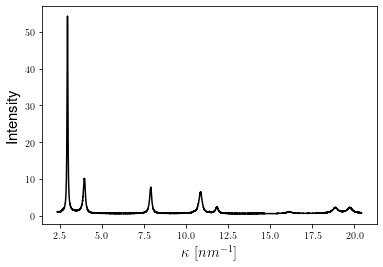

In [85]:
sample = np.loadtxt('benchmark_spectra/NiMo_sample.dat')
plt.plot(sample[:,0], sample[:,1], '-', c='black')
plt.xlabel('$\kappa$ $[nm^{-1}]$', fontsize = 15)
plt.ylabel('Intensity', fontsize = 15)


We aim to determine the microstructural parameters of this sample, based on the __first five__ peaks. To make the spectrum ameanable to analysis with DifFault, we carry out the following preprocessing steps

- Truncate the spectrum such that only the first five peaks are visible, i.e., $\kappa \in[0, 14]$. 
- Subtract the baseline, which is primarily composed of the instrumental profile. For this step, we use the ```pybaselines``` package https://pypi.org/project/pybaselines/
- Normalize the intensity values such that the first peak has magnitude 1. 
- Interpolate the processed spectrum to be uniformly sampled from the inteval $\kappa \in[0, 14]$.
- Set the intensity values to zero for $\kappa$ smaller than the first peak location.


In [86]:
def truncate_spectrum(kappa, intensity, domain):
    isInSpectrum = np.logical_and(kappa <= domain[1],kappa >= domain[0])
    return kappa[isInSpectrum], intensity[isInSpectrum]

In [87]:
kappa, intensity_truncated = truncate_spectrum(sample[:,0], sample[:,1], [0, 14])

In [88]:
kappas_interpolated = single_peak.positive_diffraction_vectors

In [12]:

from pybaselines import whittaker
from scipy import interpolate

In [16]:
def subtract_bg_arpls(x, y, bg):
    return y - bg


def preprocess_with_arpls(x, y, kappas):
    bg = whittaker.drpls(y)[0] 

    ynew = subtractBG_arpls(x, y, bg)
    f = interpolate.interp1d(x, ynew, bounds_error = False, fill_value = 0)
    spectrum = f(kappas)
    spectrum = (spectrum) / (spectrum.max() - spectrum.min())
    return spectrum - spectrum.min()

In [63]:
true_spectrum = preprocess_with_arpls(kappa, intensity_truncated, kappas_interpolated)

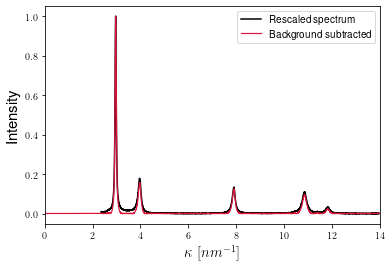

In [64]:
rescaled_sample = sample[:,1] / (sample[:,1].max() - sample[:,1].min()) 
rescaled_sample = rescaled_sample - rescaled_sample.min()
plt.plot(sample[:,0], rescaled_sample, '-', c='black', label = 'Rescaled spectrum')
plt.plot(kappas_interpolated, true_spectrum, '-', linewidth = 1.2, c='crimson', label = 'Background subtracted')
plt.xlabel('$\kappa$ $[nm^{-1}]$', fontsize = 15)
plt.ylabel('Intensity', fontsize = 15)
plt.xlim(0, 14)
plt.legend()

Let us also fix the following parameters

$$
\rho = 0.01, m = 10, R^* = 60, \sigma = 0.001,  q=2, B = 0.05
$$


In [7]:
rho_true = 0.01
m_true = 20
Rstar_true = 5
sigma_true = 0.1
q_true = 3
B_true = 0.05

### Optimization

Let us set up a loss function for the optimization. Combine all variables into a single vector first.

In [90]:
def unpack_x(x):
    m, sigma, B, rho, Rstar, q = x[:6]
    intensity = x[6:11].reshape(-1,1)
    offset = x[11:].reshape(-1,1)
    return m, sigma, B, rho, Rstar, q, intensity, offset

In [111]:
def loss(x):
    m, sigma, B, rho, Rstar, q = x[:6]
    intensity = x[6:11].reshape(-1,1)
    offset = x[11:].reshape(-1,1)
    spectrum = generate_multiple_peaks(single_peak,
                                        m,
                                        sigma,
                                       rho,
                                        Rstar,
                                        q,
                                        peak_intensities=intensity,
                                       planar_fault_probability=B,
                                       offset=offset)
    return true_spectrum.ravel() - spectrum.ravel()

Specify the initial guess for the parmeters. The initial intensity and offset values are determined by picking the relative maxima of the spectrum. Based on previous studies, we define a feasible range for the microstructural parameters. The initial values are chosen from this range following a uniform distribution.

In [78]:
from scipy.signal import find_peaks
def calculate_offsets_and_intensities(x, prominence = 0.01, height = None):
    peaks, _ = find_peaks(x, prominence=prominence, height = height)
    theoretical_peaks = np.array([3, 4, 8, 11, 12])
    peak_offsets = list(kappas_interpolated[peaks] - theoretical_peaks)
    peak_intensities = list(x[peaks])
    return peak_offsets, peak_intensities


In [29]:
rng = np.random.default_rng(1)
domains = {'B': [0, 0.05],
           'm': [5., 100.],
           'sigma': [0.1, 1.],
           'rho': [0.0005, 0.05],
           'Rstar' : [2., 100.],
           'q' : [1.5, 2.3]
          }



In [79]:
np.random.seed(3)
m_init = rng.uniform(low = domains['m'][0], high = domains['m'][1])
sigma_init = rng.uniform(low = domains['sigma'][0], high = domains['sigma'][1])
B_init = rng.uniform(low = domains['B'][0], high = domains['B'][1])
rho_init = rng.uniform(low = domains['rho'][0], high = domains['rho'][1])
Rstar_init = rng.uniform(low = domains['Rstar'][0], high = domains['Rstar'][1])
q_init = rng.uniform(low = domains['q'][0], high = domains['q'][1])
offsets_init, intensities_init = calculate_offsets_and_intensities(true_spectrum)


We also impose these bounds for the least squares regression. 

In [80]:
intensity_min = 0.001
intensity_max = 1.1

bounds1 = [domains['m'][0],
           domains['sigma'][0], 
           domains['B'][0],
           domains['rho'][0],
           domains['Rstar'][0],
           domains['q'][0],
            intensity_min, intensity_min, intensity_min, intensity_min,intensity_min, 
           -0.5, -0.5,-0.5, -0.5, -0.5]
bounds2 = [domains['m'][1],
           domains['sigma'][1],
           domains['B'][1],
           domains['rho'][1],
           domains['Rstar'][1],
           domains['q'][1],
            intensity_max, intensity_max,intensity_max, intensity_max, intensity_max,
           0.5, 0.5, 0.5, 0.5, 0.5]

In [113]:
x_0 = np.concatenate(([m_init, sigma_init, B_init, rho_init, Rstar_init, q_init], intensities_init, offsets_init))

In [115]:
from scipy.optimize import least_squares

In [116]:
res_constrained  = least_squares(loss, x_0, ftol = 1e-5, bounds = (bounds1, bounds2),
                                     verbose = 2, jac = '2-point')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5233e+00                                    2.98e+00    
       1              4         1.8925e+00      6.31e-01       1.23e+00       2.69e+00    
       2              7         8.5592e-01      1.04e+00       3.49e-02       1.01e+00    
       3              8         5.8898e-01      2.67e-01       8.63e-02       2.49e+00    
       4              9         3.9378e-01      1.95e-01       9.82e-02       1.13e+00    
       5             11         2.6160e-01      1.32e-01       7.17e-03       1.48e-01    
       6             13         2.4182e-01      1.98e-02       5.23e-03       1.38e-01    
       7             15         2.2445e-01      1.74e-02       3.47e-03       6.46e-01    
       8             16         1.9482e-01      2.96e-02       7.67e-03       1.54e-01    
       9             17         1.8365e-01      1.12e-02       1.94e-02       1.02e-01    

In [118]:
m, sigma, B, rho, Rstar, q, intensity, offset = unpack_x(res_constrained.x)

In [119]:
predicted_spectrum = generate_multiple_peaks(single_peak,
                                        m,
                                        sigma,
                                        rho,
                                        Rstar,
                                        q,
                                        peak_intensities = intensity,
                                        planar_fault_probability = B,
                                        offset = offset)

Text(0, 0.5, 'Intensity')

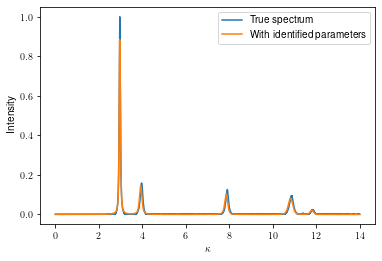

In [120]:
plt.plot(single_peak.positive_diffraction_vectors, true_spectrum, label = 'True spectrum')
plt.plot(single_peak.positive_diffraction_vectors, predicted_spectrum, label = 'With identified parameters')
plt.legend()
plt.xlabel('$\\kappa$')
plt.ylabel('Intensity')


Text(0, 0.5, 'Error')

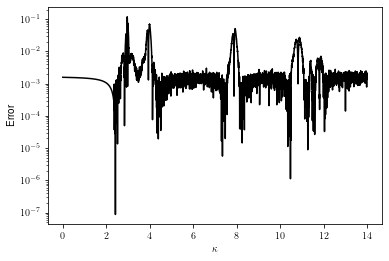

In [124]:
plt.semilogy(single_peak.positive_diffraction_vectors, np.abs(true_spectrum-predicted_spectrum.ravel()), c='black')
plt.xlabel('$\\kappa$')
plt.ylabel('Error')
